In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from PIL import Image
from reward import Reward
from helper import detect, capture, pad_inner_array, SocketListener, DataQueue
from pynput import keyboard
from pynput.keyboard import Controller, Key
from concurrent.futures import ThreadPoolExecutor
from collections import deque
import mss
import time
import pathlib
import os
import json
import random
import logging
import warnings
import sys

In [2]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5
    !pip install -r yolov5/requirements.txt

warnings.simplefilter("ignore", FutureWarning)
logging.getLogger('ultralytics').setLevel(logging.ERROR)

In [3]:
class AC_Net(nn.Module):
  def __init__(self, input, action_space):
    super(AC_Net, self).__init__()
    self.lstm = nn.LSTM(input[1] * input[2], 128, batch_first=True)
    self.fc1 = nn.Linear(128, 128)
    self.fc2 = nn.Linear(128, 128)
    self.actors = nn.ModuleList([nn.Linear(128, action.n) for action in action_space])
    self.critic = nn.Linear(128, 1)
    
    for layer in [self.fc1, self.fc2, *self.actors, self.critic]:
      nn.init.xavier_uniform_(layer.weight)
      nn.init.constant_(layer.bias, 0)
    
  def forward(self, x, hx=None):
    x = x.view(1, x.size(0), -1)
    x, hx = self.lstm(x, hx)
    x = x[:, -1, :]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = nn.Dropout(0.3)(x)
     
    return [actor(x) for actor in self.actors], self.critic(x), hx

In [ ]:
# # DEBUG: DELETE LATER
# def printd(message, debug_file="C:\\tmp\\debug_output.txt"):
#   with open(debug_file, "a") as debug_console:
#       debug_console.write(str(message) + "\n")

In [ ]:
class SimOsuEnvironment(gym.Env):
  def __init__(self, stacked_frames=1, max_notes=8, render_mode=False):
    # Common parameters
    self.max_notes = max_notes
    self.stacked_frames = stacked_frames
    self.keys_reference = ['s', 'd', 'k', 'l'] # Used for keyboard input with index corresponding to a lane
    self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(self.stacked_frames, self.max_notes, 3))
    self.action_space = gym.spaces.MultiDiscrete([4] * len(self.keys_reference))
    self.observation = np.zeros((self.max_notes, 3))
    self.frame_buf = deque(maxlen=self.stacked_frames)
    self.terminated = False
    
    self.reward_scale = 1 # Scaling reward to avoid extremely small values
    self.invalid_actions = 0 # Counts the number of invalid actions in a step
    self.invalid_action_penalty = -0.1
    self.invalid_action_penalty_scaled = 0 # Scaled invalid action penalty, to be set in reset
    self.total_invalid_actions = 0
    self.actions_taken = np.zeros((4, 4))
    
    self.executor = ThreadPoolExecutor()
    self.reward_func = Reward()
    self.model = None 
    
    self.frame_notes = [] # A note representation of each frame
    
    # Parameters for render mode
    if render_mode:
      self.render_mode = render_mode
      self.capture_region = None
      self.keyboard = Controller()
      self.data_queue = DataQueue()
      self.listener = None
      self.listener = SocketListener()
      self.listener.start(data_handler=self.data_queue.add, traceback=False)
      
    self._vision_setup()
    
    # Parameters for simulated mode
    self.custom_reward = [8, 10, 1, -3, -2, -1, -1, -2, -1] # Custom reward function to be used with Reward class
    self.custom_reward_scaled = []  # Scaled custom reward, to be set in reset
    self.chosen_folder = None # A randomly chosen folder from available_folders, to be set in reset
    self.available_folders = os.listdir('./frames/rl_simulated_training_sample')
    self.frames = [] # A list of frames in the chosen folder, to be set in reset
    self.metadata = { # Metadata of the chosen song, to be set in reset
      'song_name': "No metadata in render mode",
      'song_duration': 0,
      'note_count': 0,
      'hold_note_count': 0,
      'difficulty': 0
    } 
    self.frame_step = 0
    self.note_count = 0
    
  def reset(self):
    for _ in range(self.stacked_frames):
      self.frame_buf.append(np.zeros((self.max_notes, 3), dtype=np.int32))
    self.observation = np.stack(self.frame_buf, axis=0)
    self.invalid_actions = 0
    self.total_invalid_actions = 0
    self.actions_taken = np.zeros((4, 4))
    self.terminated = False
    
    if self.render_mode:
      if self.listener.has_connection:
        self.listener.close_connection()
      
      self.data_queue.clear()
      self._get_random_song()
    else:
      random_folder = random.choice(self.available_folders)
      self.chosen_folder = './frames/rl_simulated_training_sample/' + random_folder
      self.frames = sorted(os.listdir(self.chosen_folder))[:-1]
      self.frame_notes = []
      self.frame_step = 0
      
      self.metadata = json.load(open(self.chosen_folder + '/metadata.json'))
      self.note_count = self.metadata['note_count'] + self.metadata['hold_note_count'] * 2
      
      self.custom_reward_scaled = [(r / self.note_count) * self.reward_scale for r in self.custom_reward]
      self.invalid_action_penalty_scaled = (self.invalid_action_penalty / self.note_count) * self.reward_scale
      self.reward_func.set_custom_rewards(self.custom_reward_scaled)
    
    return self.observation
  
  def step(self, multi_actions):
    if self.render_mode:
      self.observation, reward = self._render_mode_step(multi_actions)
    else:
      self.observation, reward = self._simulated_mode_step(multi_actions)
    
    self.frame_buf.append(self.observation)
    self.observation = np.stack(self.frame_buf, axis=0)
    
    self.total_invalid_actions += self.invalid_actions
    self.invalid_actions = 0
    info = {}
    
    return self.observation, reward, self.terminated, info
    
  def get_meta_data(self):
    '''
    Returns the metadata of the current song in the form of 
    {
      'song_name' (str), \\
      'song_duration' (int) in seconds, \\
      'note_count' (int,) \\
      'hold_note_count' (int), \\
      'difficulty' (float)
    }
    '''
    return self.metadata
  
  def _render_mode_step(self, multi_actions):
    '''
    Steps the environment in render mode, where the game is running and the game window is visible
    '''
    while self.listener.is_first_connection and not self.listener.has_connection:
      pass
    
    img = capture(self.capture_region)
    img = np.array(img)
    
    self._update_observation(img)
    
    actions, action_types = self._parse_multi_actions(multi_actions)
    self.executor.submit(self._perform_keyboard_action, actions, action_types)
    
    data = self.data_queue.get()
    self.data_queue.clear()
    reward = self.reward_func.get_in_game_reward(data, self.frame_notes[-2] if len(self.frame_notes) > 3 else []) + self.invalid_action_penalty * self.invalid_actions
    
    if not self.terminated:
      self.terminated = (not self.listener.is_first_connection and not self.listener.has_connection) or 6 in data or 7 in data
    
    # self.executor.submit(printd, data)
    
    return self.observation, reward
  
  def _simulated_mode_step(self, multi_actions):
    '''
    Steps the environment in simulated mode, where the pre-recorded frames are used as input
    '''
    img = Image.open(self.chosen_folder + '/' + self.frames[self.frame_step])
    self.frame_step += 1
    
    self._update_observation(img)
    
    actions, _ = self._parse_multi_actions(multi_actions)
    reward = self.reward_func.get_simulated_reward(actions, self.frame_notes[-2] if len(self.frame_notes) > 3 else []) + self.invalid_action_penalty_scaled * self.invalid_actions
    self.terminated = self.frame_step >= len(self.frames)
    
    return self.observation, reward
  
  def _update_observation(self, img):
    vision_thread = self.executor.submit(detect, img, self.model)
    self.observation = vision_thread.result()
    self.frame_notes.append(self.observation)
    self.observation = pad_inner_array([self.observation], [0, 0 ,0], self.max_notes)[0]
    
  def _parse_multi_actions(self, multi_actions):
    '''
    Parses the multi actions into a list of actions and their types
    '''
    parsed_actions = []
    action_type = []
    
    for action_lane, action in enumerate(multi_actions):
      self.actions_taken[action_lane][action] += 1
      
      match action:
        case 0: # Do nothing
          pass
        case 1: # Release
          if not self.reward_func.get_key_held(action_lane):
            self.invalid_actions += 1
            continue
          
          self.reward_func.update_keys_held(action_lane, False)
          
          parsed_actions.append(action_lane)
        case 2: # Press
          if self.reward_func.get_key_held(action_lane):
            self.invalid_actions += 1
            
          self.reward_func.update_keys_held(action_lane, False)
          parsed_actions.append(action_lane)
        case 3: # Hold
          if not self.reward_func.get_key_held(action_lane):
            parsed_actions.append(action_lane)
          
            self.reward_func.update_keys_held(action_lane, True)

      if action_type != 0:
        action_type.append(action)
          
    return parsed_actions, action_type
  
  def _perform_keyboard_action(self, parsed_actions, action_type):
    for action, action_type in zip(parsed_actions, action_type):
      if action_type in [2, 3]:
        self.keyboard.press(self.keys_reference[action])
        if action_type == 3:
          self.reward_func.update_keys_held(action, True)
          
      time.sleep(0.04)
      
      if action_type in [1, 2]:
        self.keyboard.release(self.keys_reference[action])
        if action_type == 1:
          self.reward_func.update_keys_held(action, False)
          
  def _get_random_song(self):
    '''
    Choose a random song using in-game menu navigation
    '''
    key_sequence = ['a', Key.esc, Key.f2] + ([Key.down] * np.random.randint(0, 6)) + [Key.enter]
    
    time.sleep(2) 
    for key in key_sequence:
      self.keyboard.press(key)
      time.sleep(0.05)
      self.keyboard.release(key)
    
    time.sleep(3)
    self.executor.submit(self._skip_intro)
  
  def _skip_intro(self):
    for _ in range(10):
      self.keyboard.press(Key.space)
      time.sleep(0.05)
      self.keyboard.release(Key.space)
      time.sleep(0.1)
   
  def _vision_setup(self):
    '''
    Sets up the vision model for object detection, also sets up capture region for render mode
    '''
    if os.name == 'nt':
      pathlib.PosixPath = pathlib.WindowsPath # https://github.com/ultralytics/yolov5/issues/10240#issuecomment-1662573188
    
    if self.render_mode:
      monitor = mss.mss().monitors[-1]
      t, l, w, h = monitor['top'], monitor['left'], monitor['width'], monitor['height']
      self.capture_region = {'left': l+int(w * 0.338), 'top': t, 'width': w-int(w * 0.673), 'height': h} 
      
    self.model = torch.hub.load('ultralytics/yolov5', 'custom', path='./models/best.pt', force_reload=True)
    

In [6]:
def train(
  ac_net,
  osu_env,
  optimizer,
  max_episode,
  stacked_frames=4,
  gamma=0.99,
  beta=0.01,
  grad_clip = 100.0,
):
  total_rewards = []
  

  for episode in range(max_episode):
    terminated = False
    states, multi_actions, rewards = [], [], []
    hx = None

    state = torch.tensor(osu_env.reset(), dtype=torch.float32)
    while not terminated:
      probs, value, hx = ac_net(state, hx)
      action = []

      for prob in probs:
        prob = F.softmax(prob, dim=-1).squeeze()
        action.append(torch.distributions.Categorical(prob).sample().item())

      next_state, reward, terminated, _ = osu_env.step(action)
        
      states.append(state)
      rewards.append(reward)
      multi_actions.append(action)

      state = torch.tensor(next_state, dtype=torch.float32)
      
    R = 0 if terminated else value

    for i in reversed(range(len(rewards))):
      R = torch.tensor(rewards[i], dtype=torch.float32) + gamma * R
      R = R.detach()

      probs, value, hx = ac_net(states[i], hx)
      
      advantage = R - value
      policy_loss = []
      for i_a, prob in enumerate(probs):
        actions = multi_actions[i]
        softmax_probs = F.softmax(prob, dim=-1).squeeze()

        categorical_dist = torch.distributions.Categorical(softmax_probs)
        entropy = categorical_dist.entropy().sum() * beta

        log_probs = -torch.log(softmax_probs)
        policy_loss.append(log_probs[actions[i_a]] * advantage + entropy)

    value_loss = F.mse_loss(value, R)

    loss = torch.sum(torch.stack(policy_loss)) + value_loss 
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(ac_net.parameters(), grad_clip)
    optimizer.step()

    total_rewards.append(sum(rewards))
    meta_data = osu_env.get_meta_data()
    print(f'Episode {episode:<5} {"[" + meta_data["song_name"] + "] " + str(meta_data["difficulty"]):<50} Reward: {sum(rewards):>10.4f}, loss: {loss.item():>10.4f}')
    print(osu_env.reward_func.get_debug(osu_env.render_mode))
    print(osu_env.total_invalid_actions)
    print(osu_env.actions_taken)
    
  return total_rewards

In [7]:
def test(
  ac_net,
  osu_env,
  max_episode
):
  total_rewards = []
  hx = None

  for episode in range(max_episode):
    terminated = False
    truncated = False
    states, multi_actions, rewards = [], [], []

    state = torch.tensor(osu_env.reset(), dtype=torch.float32)
    while not terminated:
      probs, value, hx = ac_net(state)
      action = []

      for prob in probs:
        prob = F.softmax(prob, dim=-1).squeeze()
        action.append(torch.argmax(prob).item())

      next_state, reward, terminated, _ = osu_env.step(action)

      states.append(state)
      rewards.append(reward)
      multi_actions.append(action)

      state = torch.tensor(next_state, dtype=torch.float32)

    total_rewards.append(sum(rewards))
    meta_data = osu_env.get_meta_data()
    
    print(f'Episode {episode:<5} {"[" + meta_data["song_name"] + "] " + str(meta_data["difficulty"]):<50} Reward: {sum(rewards):>10.4f}')
    print(osu_env.reward_func.get_debug())
    print(osu_env.total_invalid_actions)
    print(osu_env.actions_taken)
    
  return total_rewards

In [8]:
osu_env = SimOsuEnvironment(max_notes=4, stacked_frames=4, render_mode=True)
ac_net = AC_Net(osu_env.observation_space.shape, osu_env.action_space)

Listening on 127.0.0.1:5555


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\tiany/.cache\torch\hub\master.zip
YOLOv5  2024-12-1 Python-3.10.6 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [9]:
#ac_net.load_state_dict(torch.load('models/ac_net.pth'))

In [ ]:
# with open("C:\\tmp\\debug_output.txt", "w") as file:
#  pass

In [11]:
max_episode = 100
optimizer = torch.optim.Adam(ac_net.parameters(), lr=0.001)
total_rewards = train(ac_net, osu_env, optimizer, max_episode)

Connection closed.
Episode 0     [No metadata in render mode] 0                     Reward:   533.2000, loss:   466.8480
{'miss': 226, 'bad': 85, 'meh': 87, 'ok': 82, 'great': 63, 'perfect': 44, 'song_cleared': 1, 'song_failed': 0}
1798
[[        311         414         593         505]
 [        640         302         333         548]
 [        612         345         433         433]
 [        434         633         535         221]]
Connection closed.
Connection closed.
Episode 1     [No metadata in render mode] 0                     Reward:   467.1000, loss:   100.0087
{'miss': 243, 'bad': 72, 'meh': 87, 'ok': 74, 'great': 68, 'perfect': 43, 'song_cleared': 1, 'song_failed': 0}
1759
[[        292         421         595         515]
 [        597         323         344         559]
 [        596         360         439         428]
 [        471         596         503         253]]
Connection closed.
Connection closed.
Episode 2     [No metadata in render mode] 0               

In [ ]:
test_rewards = test(ac_net, osu_env, 1)

Connection closed.
Episode 0     [No metadata in render mode] 0                     Reward:     0.0000
({'good_regular_notes': 0, 'good_end_holds': 0, 'good_hold': 0}, {'bad_hold': 0, 'broken_hold': 0, 'bad_press': 0, 'bad_release': 0, 'missed_notes': 0, 'unnecessary_press': 0})
0
[[          1           0           0           0]
 [          1           0           0           0]
 [          1           0           0           0]
 [          1           0           0           0]]


In [14]:
torch.save(ac_net.state_dict(), 'models/ac_net.pth')

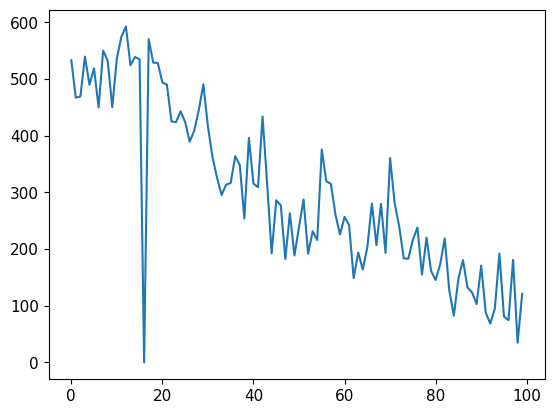

Connection closed.


In [15]:
%matplotlib inline
plt.plot(total_rewards)
plt.show()